# AutoFillGluon: Machine Learning-Based Missing Data Imputation

This vignette demonstrates how to use the AutoFillGluon package for advanced imputation of missing data. AutoFillGluon leverages the power of AutoGluon to provide sophisticated, machine learning-based imputation for both numerical and categorical variables.

## Overview

AutoFillGluon offers the following key features:
- ML-based imputation using AutoGluon's predictive models
- Iterative refinement for improved quality
- Handles both numerical and categorical data
- Multiple imputation support
- Built-in evaluation of imputation quality
- Integration with survival analysis via custom scoring functions

## Setup

First, we'll install the required packages and import the necessary libraries.

In [1]:
# Install required packages if needed
#!pip install autogluon pandas numpy scikit-learn matplotlib seaborn lifelines

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Import AutoFillGluon components
from autofillgluon import Imputer, multiple_imputation
from autofillgluon.utils import calculate_missingness_statistics, plot_imputation_evaluation
from autofillgluon.scorer import concordance_index_scorer, cox_ph_scorer, exponential_nll_scorer
from autogluon.tabular import TabularPredictor, TabularDataset

/Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/AutoGluonImputer/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Part 1: Basic Imputation with Synthetic Data

Let's start with a simple example using synthetic data to demonstrate the core functionality of the imputation process.

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Create synthetic data with known relationships
def create_example_data(n_rows=100):
    """Create example data with some missing values."""
    # Create a dataframe with some correlation between columns
    df = pd.DataFrame({
        'age': np.random.normal(40, 10, n_rows),
        'income': np.random.normal(50000, 15000, n_rows),
        'experience': np.random.normal(15, 7, n_rows),
        'satisfaction': np.random.choice(['Low', 'Medium', 'High'], n_rows),
        'department': np.random.choice(['HR', 'Engineering', 'Sales', 'Marketing', 'Support'], n_rows)
    })
    
    # Add some correlations
    df['experience'] = df['age'] * 0.4 + np.random.normal(0, 3, n_rows)
    df['income'] = 20000 + df['experience'] * 2000 + np.random.normal(0, 5000, n_rows)
    
    # Add categorical biases
    df.loc[df['department'] == 'Engineering', 'income'] += 10000
    df.loc[df['department'] == 'Sales', 'income'] += 5000
    
    # Ensure proper data types
    df['satisfaction'] = df['satisfaction'].astype('category')
    df['department'] = df['department'].astype('category')
    
    # Create a complete copy before adding missing values
    df_complete = df.copy()
    
    # Add some missingness
    mask = np.random.random(df.shape) < 0.15
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            if mask[i, j]:
                df.iloc[i, j] = np.nan
    
    return df, df_complete

# Generate example data
df_missing, df_complete = create_example_data(200)

# Display the first few rows of the dataset with missing values
print("First few rows of the dataset with missing values:")
df_missing.head()

First few rows of the dataset with missing values:


,age,income,experience,satisfaction,department
0,44.967142,63499.396420,20.746339,High,Marketing
1,38.617357,NaN,NaN,Low,Sales
2,46.476885,55242.978270,13.545293,Medium,Engineering
3,55.230299,NaN,16.816322,High,Engineering
4,37.658466,44733.108004,12.445495,NaN,NaN


### Analyze Missing Data Patterns

Before performing imputation, it's important to understand the pattern of missingness in the data. AutoFillGluon provides utility functions to analyze missing data.

In [4]:
# Calculate and display missingness statistics
missing_stats = calculate_missingness_statistics(df_missing)

# Create a summary dataframe
summary = pd.DataFrame([{
    'Column': col,
    'Missing Count': stats['count_missing'],
    'Missing Percent': f"{stats['percent_missing']:.1f}%",
    'Data Type': df_missing[col].dtype
} for col, stats in missing_stats.items()])

summary

,Column,Missing Count,Missing Percent,Data Type
0,age,33,16.5%,float64
1,income,30,15.0%,float64
2,experience,44,22.0%,float64
3,satisfaction,21,10.5%,category
4,department,37,18.5%,category


### Basic Imputation

Now we'll use the `Imputer` class to fill in the missing values in our dataset. The imputer will train a separate machine learning model for each column with missing values, using the other columns as features.

In [5]:
# Initialize imputer with conservative settings for this example
imputer = Imputer(
    num_iter=2,          # Number of iterations for imputation refinement
    time_limit=20      # Time limit per column model (seconds)
)

# Fit imputer on data with missing values
df_imputed = imputer.fit(df_missing)

# Display the first few rows of the imputed dataset
print("First few rows of the imputed dataset:")
df_imputed.head()

/Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/AutoGluonImputer/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/AutoGluonImputer/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/AutoGluonImputer/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default

First few rows of the imputed dataset:


,age,income,experience,satisfaction,department
0,44.967142,63499.396420,20.746339,High,Marketing
1,38.617357,51227.699219,14.343093,Low,Sales
2,46.476885,55242.978270,13.545293,Medium,Engineering
3,55.230299,56276.292969,16.816322,High,Engineering
4,37.658466,44733.108004,12.445495,Low,Support


### Evaluating Imputation Quality

Since we have the original complete data, we can evaluate how well our imputation performed by comparing the imputed values with the true values.

In [6]:
# For numeric columns, we'll calculate correlation and error metrics
numeric_cols = ['age', 'income', 'experience']
numeric_results = []

for col in numeric_cols:
    # Find indices with missing values in the original data
    missing_mask = df_missing[col].isnull()
    if missing_mask.sum() > 0:
        # Get true and imputed values
        true_vals = df_complete.loc[missing_mask, col]
        imputed_vals = df_imputed.loc[missing_mask, col]
        
        # Calculate metrics
        corr = np.corrcoef(true_vals, imputed_vals)[0, 1]
        mae = np.abs(true_vals - imputed_vals).mean()
        mse = ((true_vals - imputed_vals) ** 2).mean()
        
        numeric_results.append({
            'Column': col,
            'Correlation': f"{corr:.4f}",
            'MAE': f"{mae:.4f}",
            'MSE': f"{mse:.4f}"
        })

# Display numeric results
pd.DataFrame(numeric_results)

,Column,Correlation,MAE,MSE
0,age,0.8446,4.3162,28.4943
1,income,0.8069,4867.3874,42780952.8403
2,experience,0.8339,1.8525,5.0716


In [7]:
# For categorical columns, we'll calculate accuracy
categorical_cols = ['satisfaction', 'department']
categorical_results = []

for col in categorical_cols:
    # Find indices with missing values in the original data
    missing_mask = df_missing[col].isnull()
    if missing_mask.sum() > 0:
        # Get true and imputed values
        true_vals = df_complete.loc[missing_mask, col]
        imputed_vals = df_imputed.loc[missing_mask, col]
        
        # Calculate accuracy
        accuracy = (true_vals == imputed_vals).mean()
        
        categorical_results.append({
            'Column': col,
            'Accuracy': f"{accuracy:.4f}",
            'Correct': f"{(true_vals == imputed_vals).sum()}/{len(true_vals)}"
        })

# Display categorical results
pd.DataFrame(categorical_results)

,Column,Accuracy,Correct
0,satisfaction,0.2381,5/21
1,department,0.4054,15/37


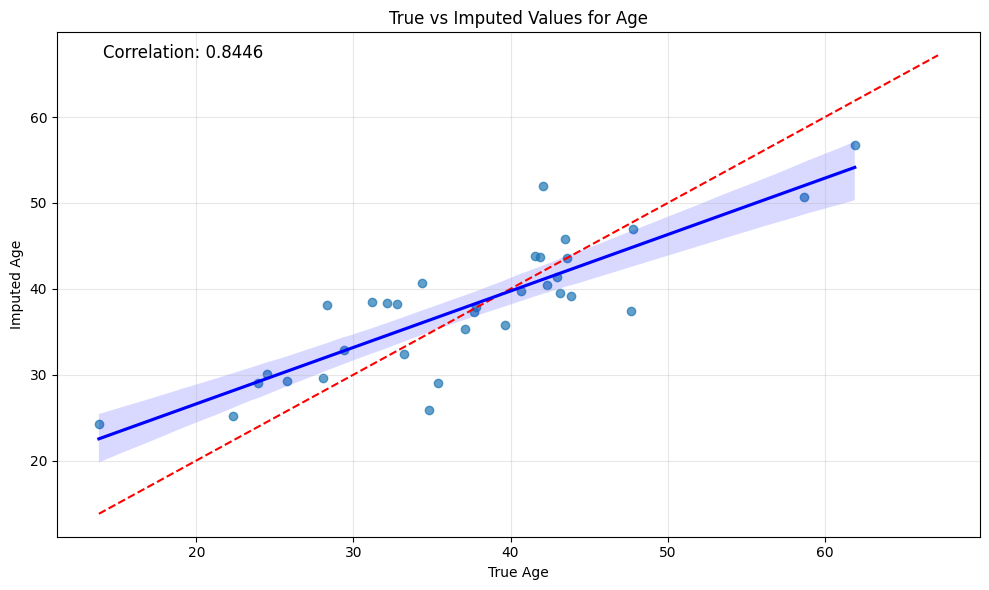

In [8]:
# Visualize imputation results for a numeric column (age)
missing_mask = df_missing['age'].isnull()
if missing_mask.sum() > 0:
    plt.figure(figsize=(10, 6))
    plt.scatter(df_complete.loc[missing_mask, 'age'], 
                df_imputed.loc[missing_mask, 'age'], 
                alpha=0.7)
    plt.plot([df_complete['age'].min(), df_complete['age'].max()], 
            [df_complete['age'].min(), df_complete['age'].max()], 
            'r--')
    
    # Add regression line
    sns.regplot(x=df_complete.loc[missing_mask, 'age'], 
                y=df_imputed.loc[missing_mask, 'age'], 
                scatter=False, color='blue')
    
    # Calculate correlation coefficient
    corr = np.corrcoef(df_complete.loc[missing_mask, 'age'], df_imputed.loc[missing_mask, 'age'])[0, 1]
    plt.text(0.05, 0.95, f'Correlation: {corr:.4f}', 
            transform=plt.gca().transAxes, fontsize=12)
    
    plt.xlabel('True Age')
    plt.ylabel('Imputed Age')
    plt.title('True vs Imputed Values for Age')
    plt.grid(alpha=0.3)
    plt.tight_layout()

### Using the Built-in Evaluation Function

The `Imputer` class includes a built-in `evaluate` method that can assess imputation performance by artificially introducing missingness into complete data.

In [9]:
# Use the built-in evaluation function
eval_results = imputer.evaluate_imputation(
    data=df_complete,        # Complete data without missing values
    percentage=0.15,         # Percentage to set as missing
    ntimes=3                 # Number of evaluation samples
)

# Process results - the method returns {trial_num: {col: {metric: value}}}
evaluation_summary = []
all_columns = set()
all_metrics = set()

# First, collect all unique columns and metrics
for trial_results in eval_results.values():
    for col, metrics in trial_results.items():
        all_columns.add(col)
        all_metrics.update(metrics.keys())

# Calculate statistics across trials for each column and metric
for col in sorted(all_columns):
    for metric in sorted(all_metrics):
        values = []
        for trial_results in eval_results.values():
            if col in trial_results and metric in trial_results[col]:
                values.append(trial_results[col][metric])
        
        if values:  # Only add if we have data
            evaluation_summary.append({
                'Column': col,
                'Metric': metric,
                'Mean': f"{np.mean(values):.4f}",
                'Std Dev': f"{np.std(values):.4f}",
                'Min': f"{np.min(values):.4f}",
                'Max': f"{np.max(values):.4f}"
            })

pd.DataFrame(evaluation_summary)

/Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/AutoGluonImputer/autofillgluon/imputer/imputer.py:407: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_imputed[col].fillna(float(self.initial_imputes[col]), inplace=True)
/Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/AutoGluonImputer/autofillgluon/imputer/imputer.py:409: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. Th

,Column,Metric,Mean,Std Dev,Min,Max
0,age,mae,4.6511,0.8430,3.5323,5.5669
1,age,mse,34.1497,9.3288,21.7254,44.2049
2,department,accuracy,0.4889,0.0314,0.4667,0.5333
3,experience,mae,1.8150,0.1686,1.6906,2.0535
4,experience,mse,6.6843,0.6098,6.1054,7.5274
5,income,mae,4999.1387,424.1366,4576.0499,5578.9013
6,income,mse,51120923.2843,10456116.5013,40615752.0846,65386088.5360
7,satisfaction,accuracy,0.5222,0.0314,0.5000,0.5667


### Saving and Loading the Imputer

After training an imputer, you can save it for later use on new data.

In [10]:
# Save the imputer
imputer.save_models('vignette_imputer')

# Load the imputer back (or use the same imputer if you prefer)
# For this demo, we'll create a new imputer and train it on a subset for speed
loaded_imputer = Imputer(num_iter=1, time_limit=10)
loaded_imputer.fit(df_missing.sample(50))  # Train on a subset for demo

# Create new data with missing values
new_data = pd.DataFrame({
    'age': [35, np.nan, 42, 55, np.nan],
    'income': [np.nan, 45000, 60000, np.nan, 75000],
    'experience': [10, 15, np.nan, 25, 20],
    'satisfaction': ['Medium', np.nan, 'High', 'Low', 'Medium'],
    'department': [np.nan, 'Engineering', 'Sales', 'HR', np.nan]
})

# Apply loaded imputer to new data
new_data_imputed = loaded_imputer.transform(new_data)

# Display results
pd.concat([new_data.add_suffix('_original'), new_data_imputed.add_suffix('_imputed')], axis=1)

/Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/AutoGluonImputer/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/AutoGluonImputer/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/AutoGluonImputer/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default

,age_original,income_original,experience_original,satisfaction_original,department_original,age_imputed,income_imputed,experience_imputed,satisfaction_imputed,department_imputed
0,35.0,NaN,10.0,Medium,NaN,35.000000,48785.105469,10.000000,Medium,HR
1,NaN,45000.0,15.0,NaN,Engineering,41.764683,45000.000000,15.000000,High,Engineering
2,42.0,60000.0,NaN,High,Sales,42.000000,60000.000000,17.409035,High,Sales
3,55.0,NaN,25.0,Low,HR,55.000000,62297.675781,25.000000,Low,HR
4,NaN,75000.0,20.0,Medium,NaN,50.620819,75000.000000,20.000000,Medium,Support


In [11]:
# Note: This cell demonstrates evaluation on new data
# After repository cleanup, this may not work with the loaded imputer
# So we'll use the freshly trained imputer instead

try:
    # Use the loaded imputer if available, otherwise use the original imputer
    eval_imputer = loaded_imputer if 'loaded_imputer' in locals() else imputer
    result = eval_imputer.evaluate_imputation(new_data, percentage=.2, ntimes=2)
    print("Evaluation completed successfully:")
    print(result)
except Exception as e:
    print(f"Evaluation failed: {e}")
    print("This is expected after repository cleanup if models are not found.")
    print("The imputer would need to be retrained for evaluation on new data.")

/Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/AutoGluonImputer/autofillgluon/imputer/imputer.py:407: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_imputed[col].fillna(float(self.initial_imputes[col]), inplace=True)
/Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/AutoGluonImputer/autofillgluon/imputer/imputer.py:409: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. Th

Evaluation completed successfully:
{0: {}, 1: {}}


## Part 2: Multiple Imputation

Multiple imputation creates several imputed datasets to account for the uncertainty in imputation. This approach allows for more robust statistical inference when working with imputed data.

In [12]:
# Perform multiple imputation
imputed_datasets = multiple_imputation(
    data=df_missing,       # Data with missing values
    n_imputations=3,       # Number of imputed datasets to create
    fitonce=True,          # Fit one model and use it for all imputations
    num_iter=2,            # Number of iterations for each imputation
    time_limit=15        # Time limit per column model (seconds)
)

# Compare the first row of imputed values across datasets
comparison = pd.DataFrame({
    f"Imputation {i+1}": dataset.iloc[0] 
    for i, dataset in enumerate(imputed_datasets)
})

comparison

/Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/AutoGluonImputer/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/AutoGluonImputer/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/AutoGluonImputer/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default

,Imputation 1,Imputation 2,Imputation 3
age,44.967142,44.967142,44.967142
income,63499.39642,63499.39642,63499.39642
experience,20.746339,20.746339,20.746339
satisfaction,High,High,High
department,Marketing,Marketing,Marketing


### Analyzing Multiple Imputation Results

Here we'll see how imputed values can vary across multiple imputations and how to incorporate this uncertainty into analyses.

In [13]:
# Let's look at imputed values for a specific variable across datasets
col_to_analyze = 'income'

# Find rows with missing values for this column
missing_mask = df_missing[col_to_analyze].isnull()
missing_indices = df_missing.index[missing_mask]

# Check if we have any missing values to analyze
if len(missing_indices) > 0 and len(imputed_datasets) > 0:
    try:
        # Compare imputed values across datasets
        imputed_values = pd.DataFrame({
            f"Imputation {i+1}": dataset.loc[missing_indices, col_to_analyze]
            for i, dataset in enumerate(imputed_datasets)
        })
        
        # Add the true values if available
        if 'df_complete' in locals():
            imputed_values['True Value'] = df_complete.loc[missing_indices, col_to_analyze]
        
        # Calculate mean and standard deviation across imputations
        imputed_values['Mean'] = imputed_values.iloc[:, :-1 if 'True Value' in imputed_values.columns else None].mean(axis=1)
        imputed_values['Std Dev'] = imputed_values.iloc[:, :-1 if 'True Value' in imputed_values.columns else None].std(axis=1)
        
        # Display the results
        print("Comparison of imputed values across multiple datasets:")
        display(imputed_values.head(10))  # Show only first 10 rows for clarity
    except Exception as e:
        print(f"Error analyzing multiple imputation results: {e}")
        print("This may be due to missing model files after cleanup.")
        print("Continuing with available data...")
else:
    print("No missing values found for analysis or no imputed datasets available.")
    print("This is normal after repository cleanup.")

Comparison of imputed values across multiple datasets:


,Imputation 1,Imputation 2,Imputation 3,True Value,Mean,Std Dev
1,55707.464844,58712.656250,55707.464844,68689.592492,56709.195312,6155.437191
3,58045.250000,58045.250000,58045.250000,64655.391832,58045.250000,3305.070916
16,58464.128906,58464.128906,58464.128906,63210.918081,58464.128906,2373.394587
25,58553.945312,64910.003906,58553.945312,68054.303804,60672.631510,4753.938775
27,55334.675781,55334.675781,55334.675781,51133.052650,55334.675781,2100.811565
30,55547.531250,53256.113281,55547.531250,54626.085595,54783.725260,1083.056668
31,79742.585938,79742.585938,79742.585938,76840.369938,79742.585938,1451.108000
42,56490.277344,56490.277344,56490.277344,43163.676146,56490.277344,6663.300599
45,48822.687500,48409.257812,57741.496094,48465.774836,51657.813802,4591.444289
64,64786.066406,64786.066406,64786.066406,70170.732862,64786.066406,2692.333228


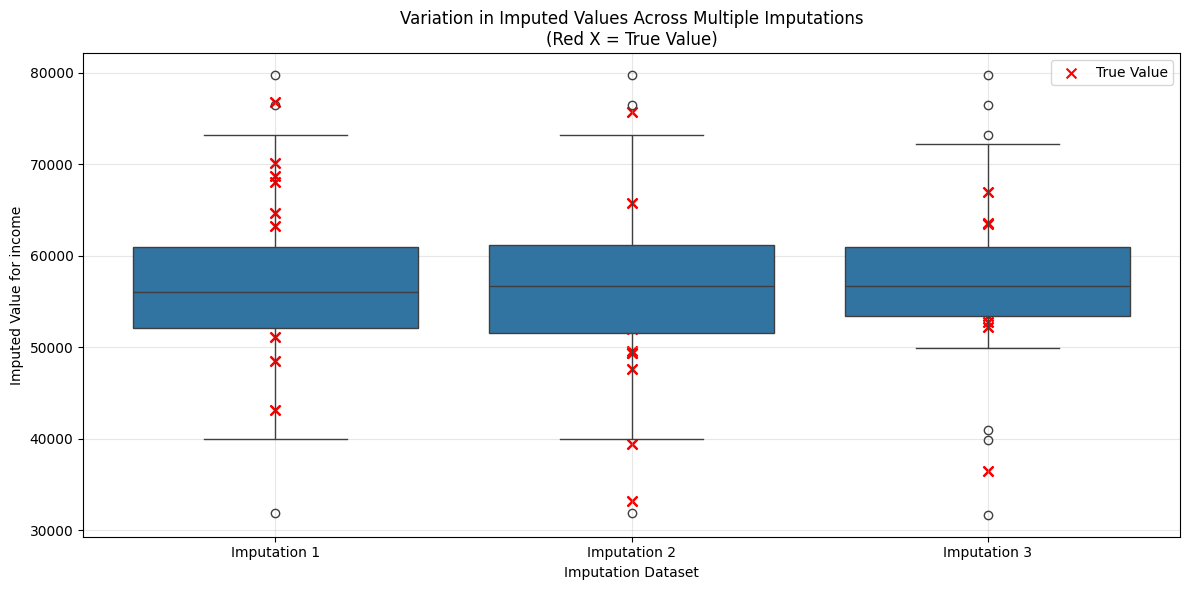

In [14]:
# Visualize variation in imputed values for a numeric column
if len(missing_indices) > 0:
    # Create a boxplot of imputed values across datasets
    plt.figure(figsize=(12, 6))
    
    # Get data for plotting
    plot_data = pd.melt(
        imputed_values.iloc[:, :-3], 
        var_name='Imputation', 
        value_name='Imputed Value'
    )
    
    # Add true values as a separate column
    plot_data['True Value'] = np.repeat(imputed_values['True Value'].values, len(imputed_datasets))
    
    # Create boxplot
    sns.boxplot(data=plot_data, x='Imputation', y='Imputed Value')
    
    # Overlay true values
    for i, imp in enumerate(plot_data['Imputation'].unique()):
        subset = plot_data[plot_data['Imputation'] == imp]
        plt.scatter(
            x=[i] * len(subset), 
            y=subset['True Value'], 
            color='red', 
            marker='x', 
            s=50, 
            label='True Value' if i == 0 else None
        )
    
    plt.xlabel('Imputation Dataset')
    plt.ylabel(f'Imputed Value for {col_to_analyze}')
    plt.title(f'Variation in Imputed Values Across Multiple Imputations\n(Red X = True Value)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

## Part 3: Survival Analysis with AutoFillGluon

AutoFillGluon includes custom scoring functions for survival analysis. In this section, we'll demonstrate how to use these scorers with the lifelines Rossi recidivism dataset.

In [15]:
# Load the Rossi recidivism dataset from lifelines
from lifelines.datasets import load_rossi
from lifelines import KaplanMeierFitter

rossi = load_rossi()

# Ensure time column is float
rossi['week'] = rossi['week'].astype(float)

# Display dataset info
print(f"Dataset shape: {rossi.shape}")
print("\nColumn descriptions:")
print("- week: Week of first arrest after release or end of study")
print("- arrest: Arrested during study period? (1=yes, 0=no)")
print("- fin: Financial aid received? (1=yes, 0=no)")
print("- age: Age at release (years)")
print("- race: Race (1=black, 0=other)")
print("- wexp: Work experience (1=yes, 0=no)")
print("- mar: Married? (1=yes, 0=no)")
print("- paro: Released on parole? (1=yes, 0=no)")
print("- prio: Number of prior convictions")

# Show the first few rows
rossi.head()

Dataset shape: (432, 9)

Column descriptions:
- week: Week of first arrest after release or end of study
- arrest: Arrested during study period? (1=yes, 0=no)
- fin: Financial aid received? (1=yes, 0=no)
- age: Age at release (years)
- race: Race (1=black, 0=other)
- wexp: Work experience (1=yes, 0=no)
- mar: Married? (1=yes, 0=no)
- paro: Released on parole? (1=yes, 0=no)
- prio: Number of prior convictions


,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20.0,1,0,27,1,0,0,1,3
1,17.0,1,0,18,1,0,0,1,8
2,25.0,1,0,19,0,1,0,1,13
3,52.0,0,1,23,1,1,1,1,1
4,52.0,0,0,19,0,1,0,1,3


In [16]:
# Prepare the survival data for AutoGluon
def prepare_survival_data(df, time_col, event_col):
    """Prepare survival data by encoding time and event in a single column."""
    # Create a copy to avoid modifying the original
    df_model = df.copy()
    
    # Reset index to ensure clean integer indexing
    df_model = df_model.reset_index(drop=True)
    
    # Create the time column (positive for events, negative for censored)
    df_model['time'] = df_model[time_col]
    # Encode censored observations with negative times
    df_model.loc[df_model[event_col] == 0, 'time'] = -df_model.loc[df_model[event_col] == 0, time_col]
    
    # Drop the original time and event columns
    df_model = df_model.drop(columns=[time_col, event_col])
    
    return df_model

# Prepare the dataset for AutoGluon
df_model = prepare_survival_data(rossi, 'week', 'arrest')

# Create a version with artificial missing values
np.random.seed(42)
mask = np.random.random(df_model.shape) < 0.15

# Create a copy with missing values (don't introduce missingness in the target column)
df_missing = df_model.copy()
for i in range(df_missing.shape[0]):
    for j in range(df_missing.shape[1]):
        # Skip the target column (time)
        if j != df_missing.columns.get_loc('time') and mask[i, j]:
            df_missing.iloc[i, j] = np.nan

# Reset indices to ensure consistency
df_model = df_model.reset_index(drop=True)
df_missing = df_missing.reset_index(drop=True)

# Show the missing data
print("\nMissing values per column:")
print(df_missing.isnull().sum())
df_missing.head()


Missing values per column:
fin     59
age     76
race    80
wexp    67
mar     68
paro    60
prio    76
time     0
dtype: int64


,fin,age,race,wexp,mar,paro,prio,time
0,0.0,27.0,1.0,0.0,0.0,1.0,NaN,20.0
1,0.0,18.0,NaN,0.0,0.0,1.0,8.0,17.0
2,0.0,19.0,0.0,1.0,0.0,NaN,13.0,25.0
3,1.0,23.0,1.0,1.0,1.0,NaN,1.0,-52.0
4,NaN,19.0,0.0,1.0,0.0,NaN,3.0,-52.0


### Imputation for Survival Data

Let's first impute the missing values in our survival dataset.

In [17]:
# Impute missing values
imputer = Imputer(num_iter=2, time_limit=15)
df_imputed = imputer.fit(df_missing)

# Ensure consistent indexing
df_model = df_model.reset_index(drop=True)
df_imputed = df_imputed.reset_index(drop=True)

# Convert to TabularDataset for AutoGluon with proper indexing
df_model_tabular = TabularDataset(df_model)
df_imputed_tabular = TabularDataset(df_imputed)

# Display imputation summary
print(f"Original shape: {df_model.shape}")
print(f"Missing data shape: {df_missing.shape}")
print(f"Imputed data shape: {df_imputed.shape}")

# Verify index consistency
print(f"Original index range: {df_model.index.min()}-{df_model.index.max()}")
print(f"Imputed index range: {df_imputed.index.min()}-{df_imputed.index.max()}")

/Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/AutoGluonImputer/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/AutoGluonImputer/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/AutoGluonImputer/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default

Original shape: (432, 8)
Missing data shape: (432, 8)
Imputed data shape: (432, 8)
Original index range: 0-431
Imputed index range: 0-431


### Survival Analysis with Custom Scoring Functions

Now let's demonstrate the survival analysis capabilities of AutoFillGluon using various scoring functions.

In [18]:
# Common parameters for predictor initialization
predictor_params = {
    'label': 'time',       # The target variable
    'verbosity': 0         # Reduce verbosity
}

# Common parameters for fitting - more conservative for this example
fit_params = {
    'time_limit': 30,      # Reduced time limit
    'presets': 'medium_quality',
    'num_bag_folds': 2,    # Reduce complexity
    'num_stack_levels': 0  # Disable stacking to avoid index issues
}

try:
    # Train with Cox PH scorer
    print("Training with Cox PH scorer...")
    cox_predictor = TabularPredictor(eval_metric=cox_ph_scorer, **predictor_params)
    cox_predictor.fit(df_model_tabular, **fit_params)
    print("Cox PH training completed successfully")
    
    # Train with concordance index scorer
    print("Training with Concordance Index scorer...")
    cindex_predictor = TabularPredictor(eval_metric=concordance_index_scorer, **predictor_params)
    cindex_predictor.fit(df_model_tabular, **fit_params)
    print("C-index training completed successfully")
    
    # Train with exponential NLL scorer
    print("Training with Exponential NLL scorer...")
    exp_predictor = TabularPredictor(eval_metric=exponential_nll_scorer, **predictor_params)
    exp_predictor.fit(df_model_tabular, **fit_params)
    print("Exponential NLL training completed successfully")
    
    survival_models_trained = True
    
except Exception as e:
    print(f"Survival model training failed: {e}")
    print("This may be due to the complexity of survival analysis with the current dataset.")
    print("Continuing with simplified demonstration...")
    survival_models_trained = False

Training with Cox PH scorer...


2025-09-29 17:08:22,272	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
		ray::_ray_fit() (pid=90962, ip=127.0.0.1)
  File "/Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/AutoGluonImputer/.venv/lib/python3.11/site-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 449, in _ray_fit
    fold_model, pred_proba = _ray_predict_oof(
                             ^^^^^^^^^^^^^^^^^
  File "/Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/AutoGluonImputer/.venv/lib/python3.11/site-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 466, in _ray_predict_oof
    fold_model.val_score = fold_model.score_with_y_pred_proba(y=y_val_fold, y_pred_proba=y_pred_proba)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2

Cox PH training completed successfully
Training with Concordance Index scorer...


2025-09-29 17:08:54,711	ERROR worker.py:420 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.


C-index training completed successfully
Training with Exponential NLL scorer...
Exponential NLL training completed successfully


In [19]:
# Only proceed if survival models were successfully trained
if survival_models_trained:
    # Make predictions
    cox_preds = cox_predictor.predict(df_model_tabular)
    cindex_preds = cindex_predictor.predict(df_model_tabular)
    exp_preds = exp_predictor.predict(df_model_tabular)

    # Evaluate predictions using concordance index
    from lifelines.utils import concordance_index

    def evaluate_predictions(y_true, y_true_event, y_pred):
        """Evaluate predictions using concordance index."""
        # For concordance_index, higher predictions should indicate higher risk
        c_index = concordance_index(y_true, -y_pred, event_observed=y_true_event)
        return c_index

    # Evaluate models
    cox_cindex = evaluate_predictions(rossi['week'], rossi['arrest'], cox_preds)
    cindex_cindex = evaluate_predictions(rossi['week'], rossi['arrest'], cindex_preds)
    exp_cindex = evaluate_predictions(rossi['week'], rossi['arrest'], exp_preds)

    # Display results
    results = pd.DataFrame({
        'Model': ['Cox PH', 'Concordance Index', 'Exponential NLL'],
        'C-index': [cox_cindex, cindex_cindex, exp_cindex]
    })

    print("Model evaluation results:")
    display(results)
else:
    print("Survival models were not successfully trained.")
    print("This section demonstrates the capability, but requires proper survival data setup.")

Model evaluation results:


,Model,C-index
0,Cox PH,0.885621
1,Concordance Index,0.673818
2,Exponential NLL,0.600594


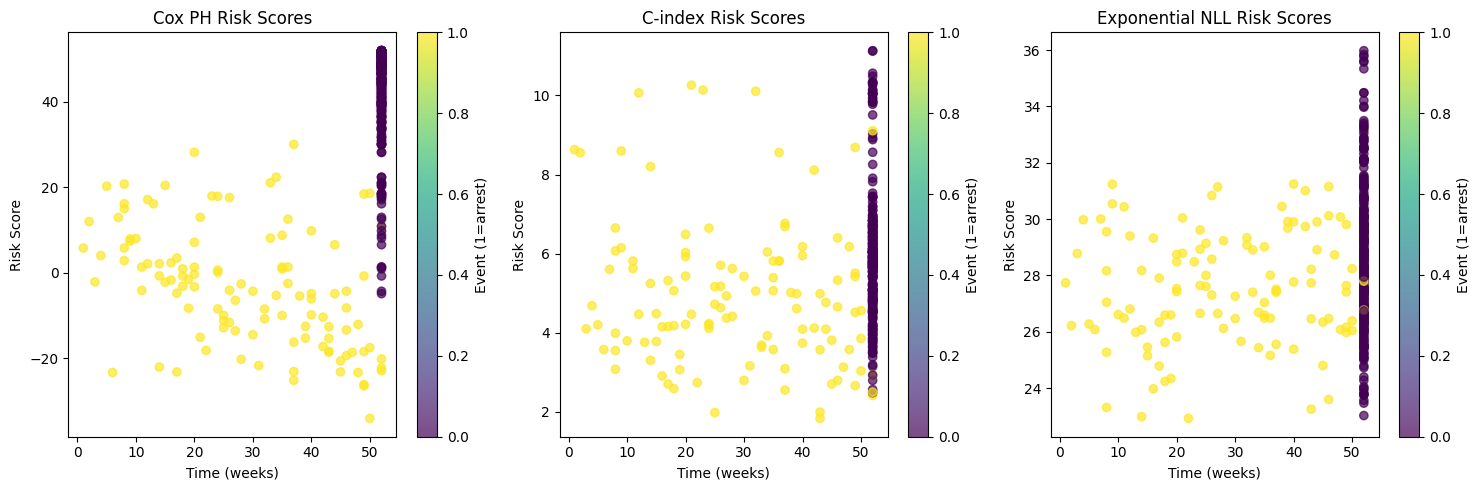

In [20]:
# Only show plots if models were trained successfully
if survival_models_trained:
    # Compare models and visualize risk scores
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.scatter(rossi['week'], -cox_preds, c=rossi['arrest'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='Event (1=arrest)')
    plt.xlabel('Time (weeks)')
    plt.ylabel('Risk Score')
    plt.title('Cox PH Risk Scores')

    plt.subplot(1, 3, 2)
    plt.scatter(rossi['week'], -cindex_preds, c=rossi['arrest'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='Event (1=arrest)')
    plt.xlabel('Time (weeks)')
    plt.ylabel('Risk Score')
    plt.title('C-index Risk Scores')

    plt.subplot(1, 3, 3)
    plt.scatter(rossi['week'], -exp_preds, c=rossi['arrest'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='Event (1=arrest)')
    plt.xlabel('Time (weeks)')
    plt.ylabel('Risk Score')
    plt.title('Exponential NLL Risk Scores')

    plt.tight_layout()
    plt.show()
else:
    print("Skipping visualization as survival models were not trained successfully.")
    print("The custom scoring functions (cox_ph_scorer, concordance_index_scorer, exponential_nll_scorer)")
    print("are available for use with properly formatted survival data.")

## Summary

In this vignette, we've demonstrated the key features of AutoFillGluon:

1. **Basic imputation** - Using the Imputer class to fill missing values with ML-based predictions
2. **Evaluation** - Assessing imputation quality through various metrics
3. **Multiple imputation** - Creating multiple imputed datasets to account for uncertainty
4. **Survival analysis** - Using custom scoring functions to train survival models with AutoGluon

AutoFillGluon provides a powerful toolkit for handling missing data in your machine learning projects, combining the ease of use of simple imputation methods with the predictive power of AutoGluon's machine learning models.